### Agent Workspace Environment


Each agent work in ubuntu environment:

```dockerfile
FROM ubuntu:latest

RUN apt-get update

RUN apt install git -y

RUN apt install python3 -y

RUN apt install python3-pip -y

RUN mkdir -p /agent_workspace

WORKDIR /agent_workspace

CMD ["/bin/bash"]
```

Create docker image:

```bash
docker build -t agent_env .
```


### Create Agent Env


In [229]:
import docker
import time

client = docker.from_env()
container_ref = None
CONTAINER_IMAGE = "agent_env"

def create_container(container_name):
    global container_ref

    existing_containers = client.containers.list(
        all=True, filters={"name": CONTAINER_NAME}
    )
    if existing_containers:
        container = existing_containers[0]
        if container.status != "running":
            container.start()
            time.sleep(20)
        container.reload()
        container_ref = container
        return "Container criado com sucesso."

    container = client.containers.run(
        CONTAINER_IMAGE,
        name=container_name,
        detach=True,
        tty=True,
        stdin_open=True,
        working_dir="/agent_workspace",
        command="/bin/bash",
    )

    time.sleep(20)

    container_ref = container
    return "Container criado com sucesso."

CONTAINER_NAME = "qa_agent_container"
create_container(CONTAINER_NAME)

'Container criado com sucesso.'

In [230]:
def delete_container(container_name):
    existing_containers = client.containers.list(
        all=True, filters={"name": container_name}
    )

    if existing_containers:
        container = existing_containers[0]
        container.stop()
        container.remove()
        return "Container deletado com sucesso."


# CONTAINER_NAME = "qa_agent_container"
# delete_container(CONTAINER_NAME)

In [231]:
def get_container():
    global container_ref

    if container_ref:
        container_ref.reload()
        if container_ref.status == "running":
            return container_ref

    containers = client.containers.list(all=True, filters={"name": CONTAINER_NAME})
    if containers:
        container = containers[0]
        if container.status != "running":
            container.start()
            time.sleep(60)
        container.reload()
        container_ref = container
        return container

    return None

### Agent

In [247]:
import json

from typing import Annotated, Literal
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [248]:
from langchain_ollama.chat_models import ChatOllama
model_name = "llama3.1"
# model_name = "mistral-nemo"

model = ChatOllama(model=model_name)

In [249]:
from langchain.tools import tool

@tool
def terminal(command: str) -> str:
    """
    Execute a shell command to be executed.
    """
    container = get_container()
    if not container:
        return "No container found. Please try again."

    try:
        result = container.exec_run(f"/bin/sh -c '{command}'")
        return result.output.decode("utf-8")

    except Exception as e:
        return f"Error executing command: {str(e)}"

In [250]:
tools = [terminal]

model_with_tools = model.bind_tools(tools)

In [251]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)

In [252]:
def expert(state: MessagesState):
    system_message = """
        You are a QA expert. You can use the tools to execute commands in the container. You are going receive requests of uses and you should ponder if you use the tools or not.
    """
    messages = state["messages"]
    response = model_with_tools.invoke([system_message] + messages)
    return {"messages": [response]}

In [253]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    
    if last_message.tool_calls:
        return "tools"
    return END

In [254]:
from langgraph.prebuilt import tools_condition

graph_builder.add_node("qa_expert", expert)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "qa_expert")
graph_builder.add_conditional_edges("qa_expert", should_continue)
graph_builder.add_edge("tools", "qa_expert")

In [255]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [256]:
graph = graph_builder.compile(checkpointer=memory)

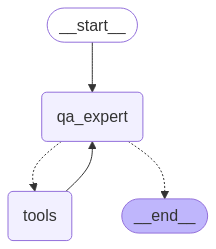

In [257]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [258]:
config = {"configurable": {"thread_id": "6"}}

In [260]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        print("User: " + user_input)
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: modifique a extensão dos dois arquivos para .md
Assistant: 
Assistant: "mv: cannot stat 'teste.txt': No such file or directory\n"
Assistant: 
Assistant: "mv: cannot stat '../novo_teste.txt': No such file or directory\n"
Assistant: 
Assistant: "mv: cannot stat 'novo_teste.txt': No such file or directory\n"
Assistant: Parece que os arquivos não estão no diretório atual. Você precisa especificar o caminho completo para os arquivos, ou movê-los para a pasta de trabalho atual antes de executar o comando.

Exemplo: "mv /caminho/novo_teste.txt nome_do_arquivo.md"
User: você esqueceu que o arquivo estava na pasta test_folder
Assistant: 
Assistant: "mv: cannot stat '/caminho/test_folder/novo_teste.txt': No such file or directory\n"
Assistant: 
Assistant: "mv: cannot stat 'test_folder/novo_teste.txt': No such file or directory\n"
Assistant: 
Assistant: "mv: cannot stat 'test_folder/novo_teste.txt': No such file or directory\n"
Assistant: 
Assistant: "mv: cannot stat 'test_folder/novo_teste